In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet 

DATA_PATH = "../DATA/Combined_UVA_Tuition_Cleaned.csv"
OUT_DIR   = "../OUTPUT/05_prophet/"
COL_YEAR  = "Year_Start"
COL_GAP   = "Tuition_Gap"

TRAIN_END_YEAR = 2013
TEST_START     = 2014
TEST_END       = 2023
FORECAST_END   = 2030

os.makedirs(OUT_DIR, exist_ok=True)

In [29]:
# metric functions
def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(y_true == 0, 1e-9, np.abs(y_true))
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def r2(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot) if ss_tot != 0 else np.nan

def directional_accuracy_last_n(y_true, y_pred, n=5):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if len(y_true) < n + 1 or len(y_pred) < n + 1:
        return np.nan
    d_true = np.sign(np.diff(y_true[-(n+1):]))
    d_pred = np.sign(np.diff(y_pred[-(n+1):]))
    return float((d_true == d_pred).mean())

In [30]:
# load data
df = pd.read_csv(DATA_PATH)
df = df[[COL_YEAR, COL_GAP]].dropna()
df[COL_YEAR] = pd.to_numeric(df[COL_YEAR], errors="coerce").astype("Int64")
df[COL_GAP] = pd.to_numeric(df[COL_GAP], errors="coerce")
df = df.dropna().sort_values(COL_YEAR).reset_index(drop=True)

df_p = pd.DataFrame({
    "ds": pd.to_datetime(df[COL_YEAR].astype(int), format="%Y"),
    "y": df[COL_GAP].astype(float)
})
df_p["year"] = df_p["ds"].dt.year


In [31]:
# train-test split
train = df_p[df_p["year"] <= TRAIN_END_YEAR]
test  = df_p[(df_p["year"] >= TEST_START) & (df_p["year"] <= TEST_END)]
print(f"Train years: {train['year'].min()}–{train['year'].max()} | Test years: {test['year'].min()}–{test['year'].max()}")


Train years: 1970–2013 | Test years: 2014–2023


In [32]:
# train model on train set
m_tr = Prophet(
    changepoint_prior_scale=0.05,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False
)
m_tr.fit(train[["ds", "y"]])


21:11:14 - cmdstanpy - INFO - Chain [1] start processing
21:11:14 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
# predict on test set
fc_test = m_tr.predict(test[["ds"]])
y_true = test["y"].values
y_pred = fc_test["yhat"].values

score_r2   = r2(y_true, y_pred)
score_mape = mape(y_true, y_pred)
dir_acc    = directional_accuracy_last_n(y_true, y_pred, n=5)

print(f"Prophet Evaluation (1970–2013 train | 2014–2023 test)")
print(f"R² = {score_r2:.3f}")
print(f"MAPE = {score_mape:.2f}%")
print(f"Directional Accuracy (last 5 years) = {dir_acc:.2f}")

pd.DataFrame({
    "year": test["year"],
    "gap_actual": y_true,
    "gap_pred_prophet": y_pred
}).to_csv(f"{OUT_DIR}/prophet_test_predictions.csv", index=False)


Prophet Evaluation (1970–2013 train | 2014–2023 test)
R² = 0.881
MAPE = 2.68%
Directional Accuracy (last 5 years) = 1.00


In [34]:
# retrain on full data and forecast to 2030
last_year = int(df_p["year"].max())
steps = max(0, FORECAST_END - last_year)

m_full = Prophet(
    changepoint_prior_scale=0.05,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False
)
m_full.fit(df_p[["ds", "y"]])

future = m_full.make_future_dataframe(periods=steps, freq="YS")
fc_full = m_full.predict(future)

fc_future = fc_full[fc_full["ds"].dt.year > last_year]
if not fc_future.empty:
    fc_future_out = pd.DataFrame({
        "year": fc_future["ds"].dt.year,
        "gap_forecast_prophet": fc_future["yhat"]
    })
    fc_future_out.to_csv(f"{OUT_DIR}/prophet_future_forecast_2030.csv", index=False)


21:11:14 - cmdstanpy - INFO - Chain [1] start processing
21:11:15 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
# save metrics
pd.DataFrame([{
    "train_period": "1970–2013",
    "test_period": "2014–2023",
    "changepoint_prior_scale": 0.05,
    "test_R2": score_r2,
    "test_MAPE": score_mape,
    "directional_accuracy_last5": dir_acc
}]).to_csv(f"{OUT_DIR}/prophet_metrics.csv", index=False)


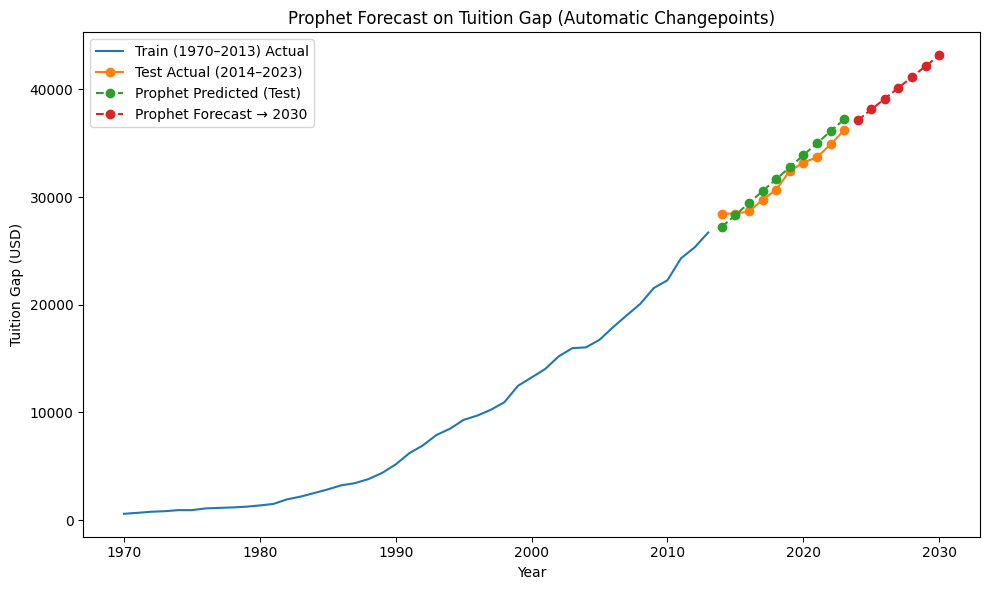

Saved: ../OUTPUT/05_prophet//prophet_test_predictions.csv, ../OUTPUT/05_prophet//prophet_future_forecast_2030.csv ../OUTPUT/05_prophet//prophet_metrics.csv, ../OUTPUT/05_prophet//prophet_gap_forecast.png


In [36]:
# plot results
plt.figure(figsize=(10,6))

plt.plot(df_p[df_p["year"] <= TRAIN_END_YEAR]["year"],
         df_p[df_p["year"] <= TRAIN_END_YEAR]["y"],
         label="Train (1970–2013) Actual")

plt.plot(df_p[(df_p["year"] >= TEST_START) & (df_p["year"] <= TEST_END)]["year"],
         df_p[(df_p["year"] >= TEST_START) & (df_p["year"] <= TEST_END)]["y"],
         marker="o", label="Test Actual (2014–2023)")

plt.plot(test["year"], y_pred, marker="o", linestyle="--", label="Prophet Predicted (Test)")

if not fc_future.empty:
    plt.plot(fc_future["ds"].dt.year, fc_future["yhat"], marker="o", linestyle="--", label="Prophet Forecast → 2030")

plt.title("Prophet Forecast on Tuition Gap (Automatic Changepoints)")
plt.xlabel("Year")
plt.ylabel("Tuition Gap (USD)")
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/prophet_gap_forecast.png", dpi=200)
plt.show()

print("Saved:",
      f"{OUT_DIR}/prophet_test_predictions.csv,",
      f"{OUT_DIR}/prophet_future_forecast_2030.csv" if not fc_future.empty else "(no future file),",
      f"{OUT_DIR}/prophet_metrics.csv,",
      f"{OUT_DIR}/prophet_gap_forecast.png")
